In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn.functional as F

In [ ]:
def analyze(db):
    acc = len(db.query('true_user == pred_cosine')) / len(db)
    
    avg_correct =  db.query('true_user == pred_cosine')['cosine_score'].mean()
    avg_wrong = db.query('true_user != pred_cosine')['cosine_score'].mean()
    
    print(f'Accuracy: {acc}')
    print(f'Average score CORRECT: {avg_correct}')
    print(f'Average score WRONG: {avg_wrong}')
    
    idx_wrong = np.where(db['pred_cosine'] != db['true_user'])
    
    return idx_wrong

In [3]:
def load_enroll(path):
    X = {}
    df = pd.read_csv(path)
    
    for idx, row in df.iterrows():
        path = row['_path']
        spk = row['spk_id']
        th_embd = torch.load(path)        
        X[spk] = th_embd
        
    return X

def load_test(path):
    X = []
    df = pd.read_csv(path)
    
    for idx, row in df.iterrows():
        path = row['_path']
        spk = row['spk_id']
        th_embd = torch.load(path)        
        X.append((th_embd, spk))
        
    return X

In [92]:
def plot_cmap(n_users_to_plot, users, tot):
    
    #norm_dict = {k:tot[k]['scores']/tot[k]['count'] for k in tot.keys()}
    #df = pd.DataFrame.from_dict(norm_dict, orient='index', columns=users)
    
    k = 0
    F = np.zeros((n_users_to_plot, n_users_to_plot))

    idx_spk_to_plot = random.sample(range(len(users)), n_users_to_plot)

    
    users_to_plot = []

    for idx in idx_spk_to_plot:

        curr_user = users[idx]
        users_to_plot.append(curr_user) # for plotting

        norm_score = tot[curr_user]['scores'] / tot[curr_user]['count']

        F[k, :] = norm_score[idx_spk_to_plot]   # add only the selected speakers
        k += 1
        
        
    ax = sns.heatmap(F, linewidth=1, cmap='viridis', vmin=-1, vmax=1)
    ax.set_xticks(np.arange(len(users_to_plot)))
    ax.set_yticks(np.arange(len(users_to_plot)))

    ax.set_yticklabels(labels=users_to_plot, rotation=0)
    ax.set_xticklabels(labels=users_to_plot, rotation=45)


    ax.set_title("Cosine similarity")
    

In [69]:
def main(path_embd_enroll, path_embd_test):
    enroll_embd = load_enroll(path_embd_enroll)
    users = list(enroll_embd.keys())
    
    test_embd = load_test(path_embd_test)
    
    # Initialize DFs
    
    DB_rows = [] 
    tot = {}
    
    # Iterate

    for to_test, test_user in test_embd:

        max_score = -10**8
        min_score = 10**8
        best_spk = None

        if test_user not in tot.keys():
            tot[test_user]= {'scores': np.zeros(50), 
                             'count': 0}

        scores = []
        for enroll_user in users:
            reference = enroll_embd[enroll_user]

            score = F.cosine_similarity(reference, to_test)
            score = score[0].data.cpu().numpy()

            scores.append(score)

            mse = ((to_test - reference) ** 2).sum().numpy()

            #print(test_user, enroll_user, score)

            if score > max_score:
                best_spk = enroll_user
                max_score = score

            if mse < min_score:
                best_mse = enroll_user
                min_score = mse
                #print('Best user updated!')

        tot[test_user]['scores'] += np.array(scores) 
        tot[test_user]['count'] += 1

        DB_rows.append([test_user, best_spk, max_score, best_mse, min_score])


    DB= pd.DataFrame(DB_rows, columns=['true_user', 'pred_cosine', 'cosine_score', 'pred_mse', 'mse_score'])
    
    return DB, tot, users

## Trained with contrastive loss

In [83]:
path_embd_test = '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/embeddings_10/test_samples.csv'
path_embd_enroll =  '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/embeddings_10/enroll_samples.csv'
DB, tot, users = main(path_embd_enroll=path_embd_enroll, path_embd_test=path_embd_test)

In [84]:
idx_wrong = analyze(DB)

Accuracy: 0.8128205128205128
Average score CORRECT: 0.9104196446175079
Average score WRONG: 0.8493028614619007


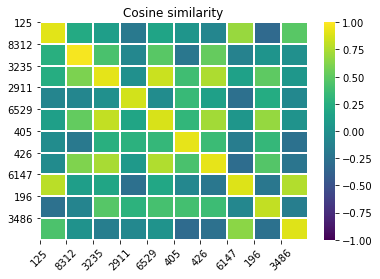

In [93]:
plot_cmap(10, users, tot)

## Trained with cross-entropy

In [70]:
embd_enroll_old = '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/tot_embeddings/enroll_samples.csv'
embd_test_old = '/cas/DeepLearn/elperu/tmp/speech_datasets/LibriSpeech/tot_embeddings/test_samples.csv'
DB_2, tot_2, users = main(path_embd_enroll=embd_enroll_old, path_embd_test=embd_test_old)

In [71]:
idx_wrong_2 = analyze(DB_2)

Accuracy: 0.8912820512820513
Average score CORRECT: 0.9954309320833933
Average score WRONG: 0.9898698914725825


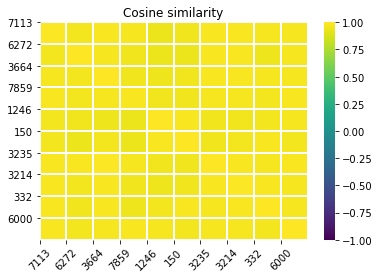

In [94]:
plot_cmap(10, users, tot_2)